<h1 align='center'>Введение в обработку естественного языка</h1>  

<h2 align='center'>Урок 11. Модель Transformer-1</h2>  

Практическое задание:
Разобраться с моделькой перевода как она устроена (c механизмом внимания), запустить для перевода с русского на английский (при желании можно взять другие пары языков)
**внимание классическое** с RNN-ками в энкодере и декодере
ноутбук в архиве
lesson11_actual.zip
называется
`nmt_with_attention.ipynb`

In [7]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## Скачиваем и обрабатываем датасет

We'll use a language dataset provided by http://www.manythings.org/anki/

In [1]:
!wget http://www.manythings.org/anki/rus-eng.zip

--2023-05-18 21:53:29--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15460248 (15M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.74M  25.6MB/s    in 0.6s    

2023-05-18 21:53:30 (25.6 MB/s) - ‘rus-eng.zip’ saved [15460248/15460248]



In [2]:
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      


In [3]:
!ls /content/rus-eng/ -lah

total 74M
drwxr-xr-x 2 root root 4.0K May 18 21:53 .
drwxr-xr-x 1 root root 4.0K May 18 21:53 ..
-rw-r--r-- 1 root root 1.5K Apr  2 03:16 _about.txt
-rw-r--r-- 1 root root  74M Apr  2 03:16 rus.txt


In [4]:
# Download the file
path_to_file = "/content/rus-eng/rus.txt"

Функция препроцессинга

In [8]:
def preprocess_sentence(w):
  w = w.lower().strip()

# вставим пробелы между словом и следующими за ним знаками препинания
  # например: "he is a boy." => "he is a boy ."
  # Источник:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # заменим всё пробелами, кроме (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # добавление начального и конечного токенов в предложение
  # так модель будет знать, когда начать и закончить предсказание  
  w = '<start> ' + w + ' <end>'
  return w

Пример:

In [9]:
preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [10]:
# 1. Уберём акценты
# 2. Вычислим предложения
# 3. Вернём пары слов в формате: [ENG, RUS]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]

  return zip(*word_pairs)

In [11]:
en, ru = create_dataset(path_to_file, None)
print(en[-1])
print(ru[-1])

<start> doubtless there exists in this world precisely the right woman for any given man to marry and vice versa but when you consider that a human being has the opportunity of being acquainted with only a few hundred people , and out of the few hundred that there are but a dozen or less whom he knows intimately , and out of the dozen , one or two friends at most , it will easily be seen , when we remember the number of millions who inhabit this world , that probably , since the earth was created , the right man has never yet met the right woman . <end>
<start> несомненно , для каждого мужчины в этом мире где то есть подходящая женщина , которая может стать ему женой , обратное верно и для женщин . но если учесть , что у человека может быть максимум несколько сотен знакомых , из которых лишь дюжина , а то и меньше , тех , кого он знает близко , а из этой дюжины у него один или от силы два друга , то можно легко увидеть , что с уч том миллионов живущих на земле людей , ни один подходящи

In [12]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer

In [13]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

### Ограничем размер набора данных для ускорения экспериментов (необязательно)



In [14]:
len(en), len(ru)

(467119, 467119)

In [15]:
# Попробуем поэкспериментировать с размером набора данных
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Подсчитаем максимальную длину (max_length) искомого тензора
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

In [16]:
# Создание обучающих и проверочных наборов с использованием разделения 80 на 20
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Посмотрим на их длину
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [17]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [18]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
4 ----> я
17836 ----> углубился
15 ----> в
9375 ----> детали
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
144 ----> went
493 ----> into
1369 ----> details
3 ----> .
2 ----> <end>


### Создадим tf.data dataset

In [19]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [20]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [21]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [22]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


In [23]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)   
    # мы делаем это, чтобы транслировать сложение по оси времени для вычисления балла
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # мы получаем 1 на последней оси, потому что мы применяем оценку к self.V
    # # форма тензора перед применением self.V равно (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [25]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # передача объединенного вектора в GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [26]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7362)


## Определим оптимизатор и функцию потерь

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [28]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [29]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - ввод таргета в качестве следующего входного сигнала
    for t in range(1, targ.shape[1]):
      # проброс enc_output в decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # использование teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [30]:
%%time

EPOCHS = 15

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # сохраняем (checkpoint) модель каждые 2 эпохи
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.6288
Epoch 1 Batch 100 Loss 2.1812
Epoch 1 Batch 200 Loss 1.7445
Epoch 1 Batch 300 Loss 1.7338
Epoch 1 Batch 400 Loss 1.5353
Epoch 1 Batch 500 Loss 1.5323
Epoch 1 Batch 600 Loss 1.4231
Epoch 1 Batch 700 Loss 1.3557
Epoch 1 Batch 800 Loss 1.3046
Epoch 1 Batch 900 Loss 1.1441
Epoch 1 Batch 1000 Loss 1.1485
Epoch 1 Batch 1100 Loss 0.9412
Epoch 1 Batch 1200 Loss 1.1029
Epoch 1 Loss 1.4813
Time taken for 1 epoch 125.60211539268494 sec

Epoch 2 Batch 0 Loss 0.9335
Epoch 2 Batch 100 Loss 0.7797
Epoch 2 Batch 200 Loss 0.7251
Epoch 2 Batch 300 Loss 0.6422
Epoch 2 Batch 400 Loss 0.8735
Epoch 2 Batch 500 Loss 0.7005
Epoch 2 Batch 600 Loss 0.6538
Epoch 2 Batch 700 Loss 0.5894
Epoch 2 Batch 800 Loss 0.5971
Epoch 2 Batch 900 Loss 0.6157
Epoch 2 Batch 1000 Loss 0.6544
Epoch 2 Batch 1100 Loss 0.4860
Epoch 2 Batch 1200 Loss 0.4455
Epoch 2 Loss 0.6573
Time taken for 1 epoch 98.51700711250305 sec

Epoch 3 Batch 0 Loss 0.3256
Epoch 3 Batch 100 Loss 0.3247
Epoch 3 Batch 200 Loss 0.36

## Перевод

* Функция оценки аналогична циклу обучения, за исключением того, что здесь мы не используем "teacher forcing". Входными данными для декодера на каждом временном шаге являются его предыдущие предсказания вместе со скрытым состоянием и выходными данными кодера.
* Прекратить прогнозирование, когда модель предскажет *конечный токен*.
* И сохранить значения *веса внимания для каждого временного шага*.

Примечание: Выходной сигнал энкодера вычисляется только один раз для одного входа.

In [31]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # сохранение весов внимания для последующего построения графика
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # прогнозируемый идентификатор вводится обратно в модель
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [32]:
# функция для печати весов внимания
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [33]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Восстановим последнюю контрольную точку и протестируем

In [34]:
# восстановим последнюю контрольную точку из checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> здесь хорошо . <end>
Predicted translation: it's fine here . <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


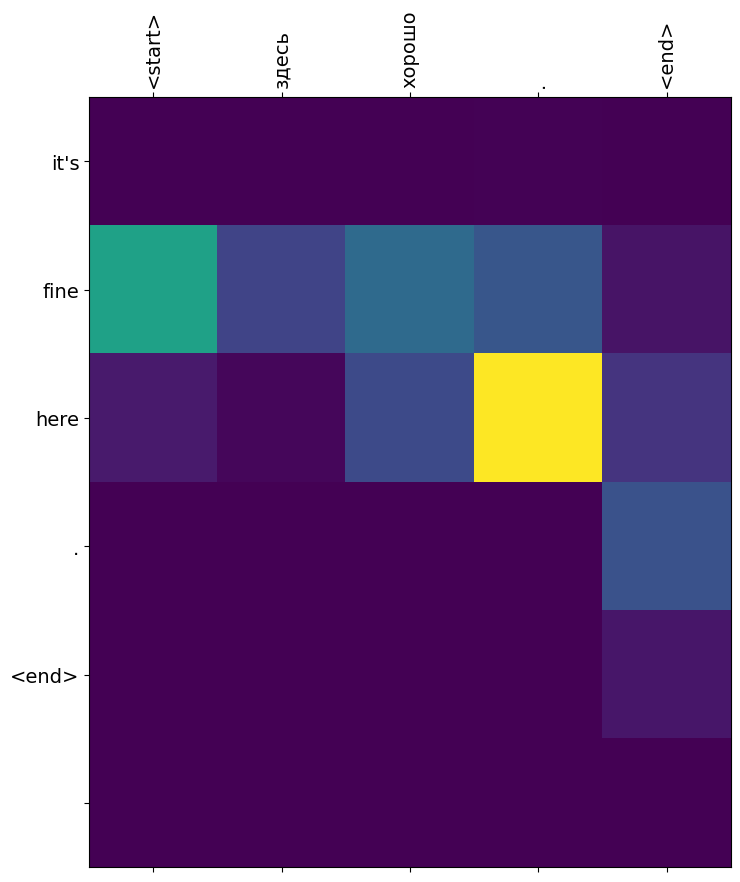

In [35]:
translate('Здесь хорошо.')

Input: <start> я не смогу поехать . <end>
Predicted translation: i can't go . <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


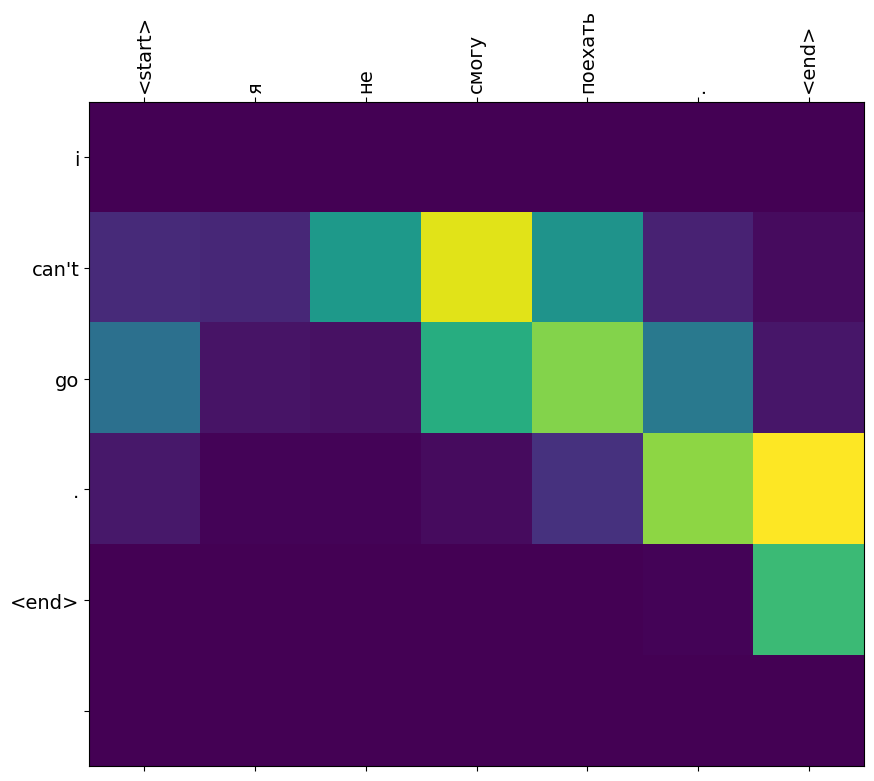

In [36]:
translate('Я не смогу поехать.')

Input: <start> вы еще дома ? <end>
Predicted translation: are you still home ? <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


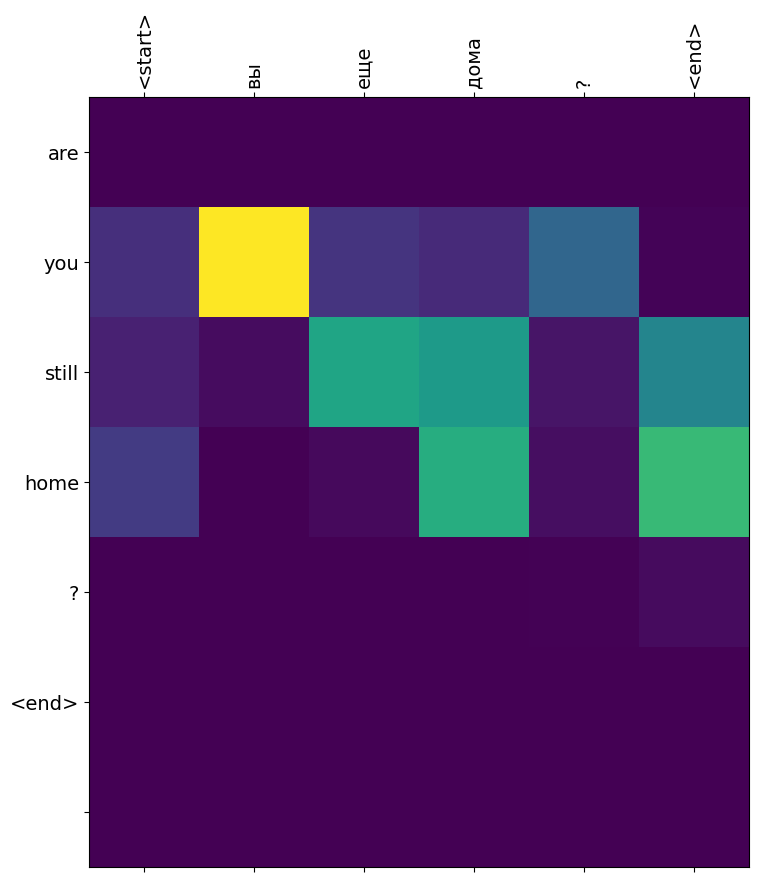

In [37]:
translate(u'Вы еще дома?')

Input: <start> вы все еще дома ? <end>
Predicted translation: are you still home ? <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


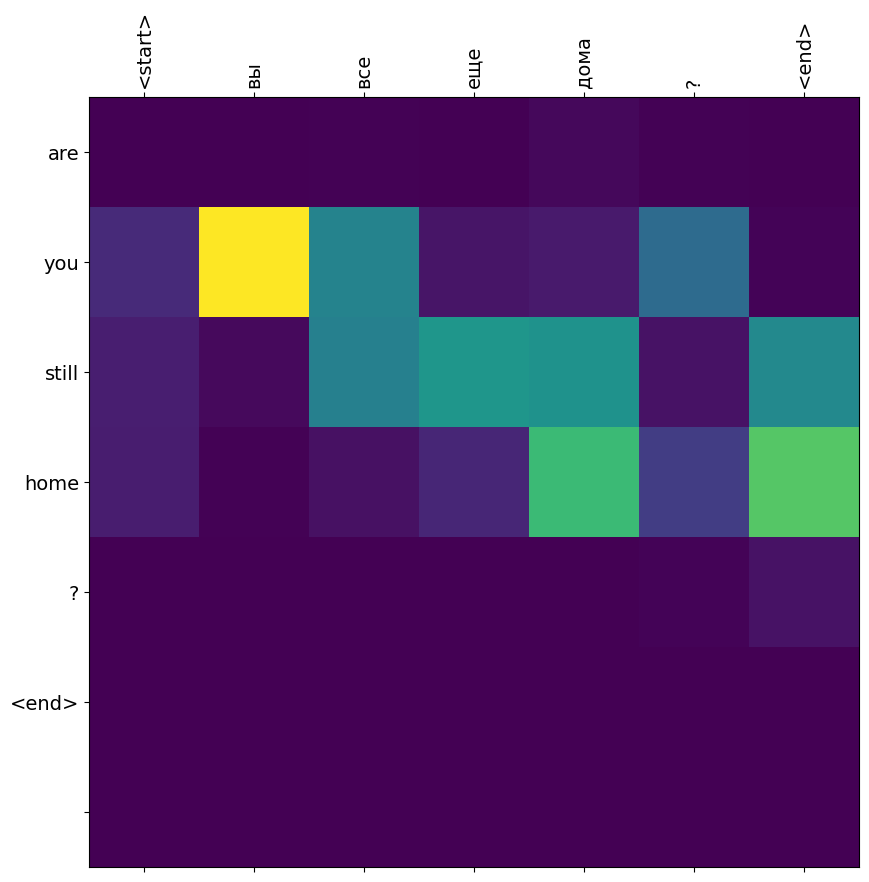

In [38]:
translate(u'Вы все еще дома?')

Input: <start> попробуй сделать это . <end>
Predicted translation: try to do it . <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


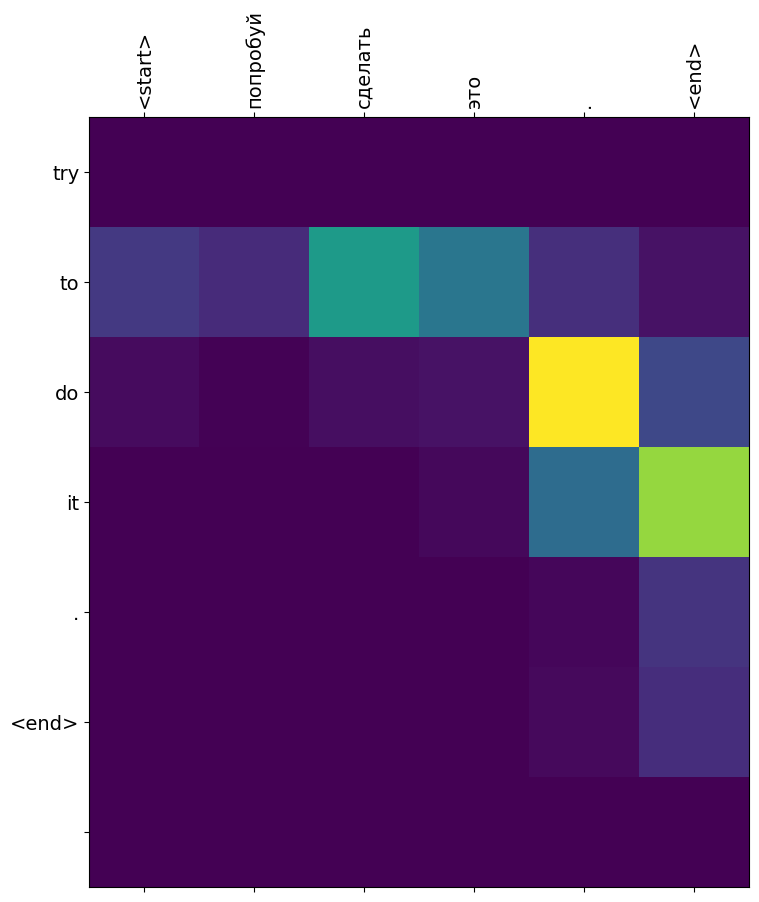

In [39]:
translate(u'Попробуй сделать это.')

Input: <start> я не люблю , когда идет снег . <end>
Predicted translation: i don't like tom sing . <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


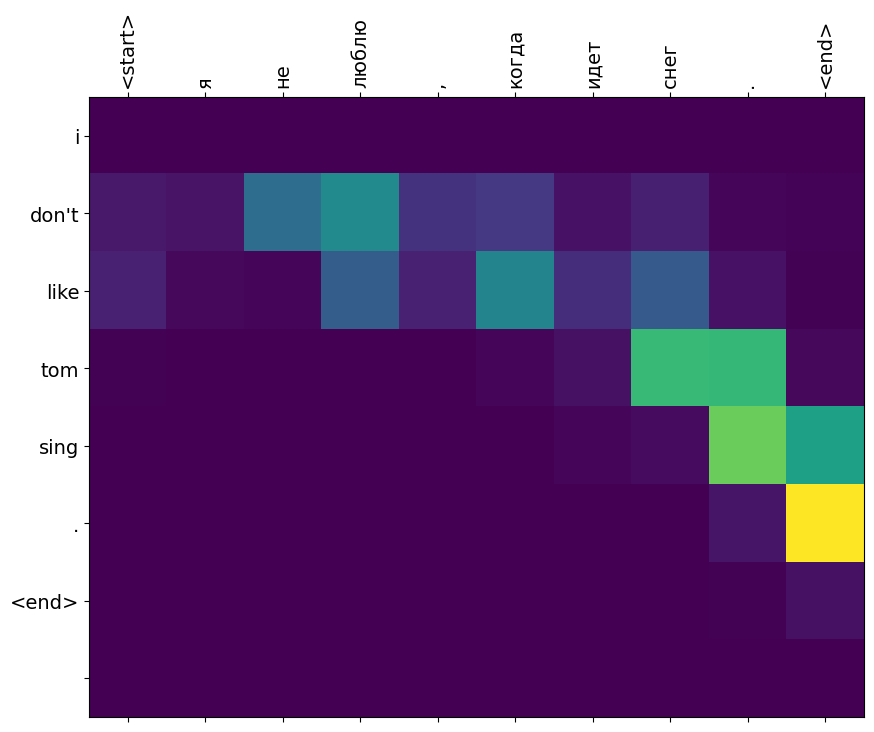

In [40]:
translate(u'Я не люблю, когда идет снег.')

Input: <start> я никогда такого не делаю . <end>
Predicted translation: i never do that . <end> 


<ipython-input-32-d1c5afd39da3>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
<ipython-input-32-d1c5afd39da3>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


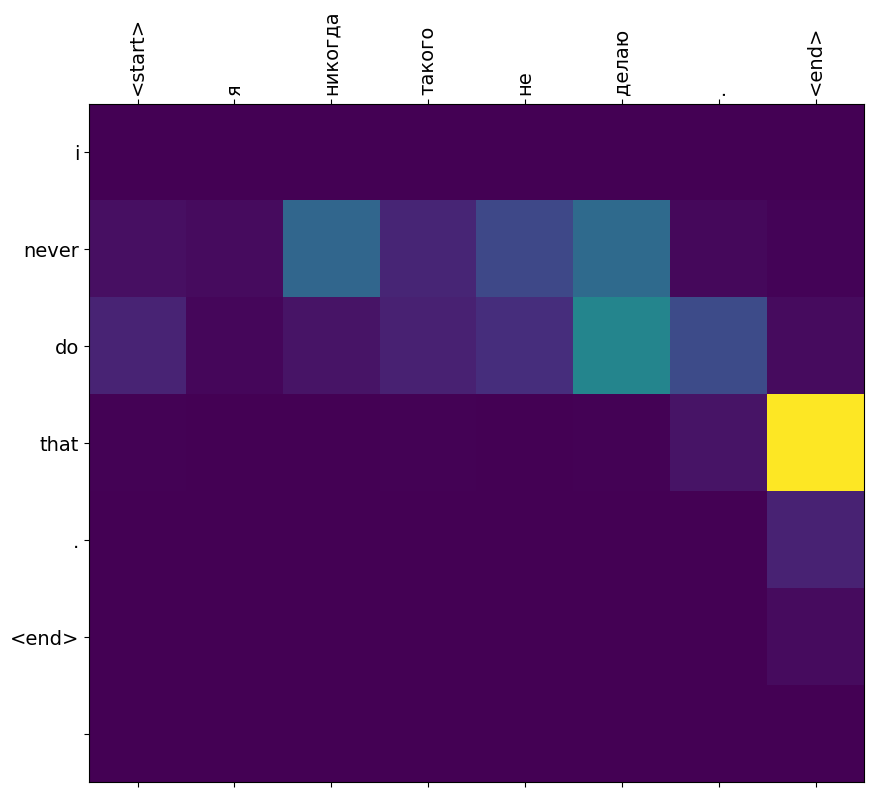

In [41]:
translate(u'Я никогда такого не делаю.')

**Вывод:**  

По сравнению с обучением без механизма внимания, обучение проходит в 1,5 - 2 раза дольше.  
Видно, что короткие предложения переводятся также достаточно хорошо. На длинных текстах (два последних) я не заметил особого улучшения. ИМХО, даже хуже. Вероятно, это из-за малого количества эпох. Если учеличить их более 15-ти качество будет повыше.